In [242]:
from datetime import datetime, timedelta
from sqlmodel import Field, Relationship, SQLModel, Session, create_engine, select, col

CYCLE_TIME = 3      # times in hours
db_name = "beboundless_data.db"
sqlite_url = f"sqlite:///{db_name}"
engine = create_engine(sqlite_url)

In [243]:
from beboundless_data_db import Requestors, Orders

one_hour_ago = int((datetime.now() - timedelta(hours=CYCLE_TIME)).timestamp())
with Session(engine) as session:
    statement = select(Requestors).where(Requestors.last_activity >= one_hour_ago)
    results: list[Requestors] = session.exec(statement).all()

address = [r.address for r in results if r.address]
print(address)

data_dict = {}
with Session(engine) as session:
    for addr in address:
        statement = select(Orders).where(
            Orders.created >= one_hour_ago,
            Orders.requestor_address == addr,
            Orders.lock_gas_price != None
        )
        orders = session.exec(statement).all()
        data_dict[addr] = [(order.order_id, order.created, order.lock_txn, order.lock_gas_price) for order in orders if order.lock_gas_price]
print(data_dict)

['0x2546c553d857d20658ece248f7c7d0861a240681', '0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0', '0x89f12aba0bcda3e708b1129eb2557b96f57b0de6', '0x734df7809c4ef94da037449c287166d114503198', '0xc73c222d7d39778bf9212f23a8f4356ff7c1e77f', '0xf353bda16a83399c11e09615ee7ac326a5a08ccf']
{'0x2546c553d857d20658ece248f7c7d0861a240681': [('0x2546c553d857d20658ece248f7c7d0861a240681f932fec7', 1756777415, '0x4e0f85fe5e5790d2800c0c9117d4b9037fc22c4b1f6ef4f3d290f55c274f78b9', 0.123), ('0x2546c553d857d20658ece248f7c7d0861a240681764fca6e', 1756777403, '0xf7fc7ebcc335410fc71ddfc9b0339a6c62d954115b186d13aaa0fc5bf512d5ed', 0.24036699), ('0x2546c553d857d20658ece248f7c7d0861a24068182eac81b', 1756777392, '0x114f3bd9df289477667b8076ab69efd4b4db61818351bdc5ea1e4efd93161ff9', 0.240353732), ('0x2546c553d857d20658ece248f7c7d0861a2406812d5bd228', 1756777381, '0xfaf444b7465babfb11e18f332543e61bc2d27a5e4e4bcd187d8cff35972f28d5', 0.050018174), ('0x2546c553d857d20658ece248f7c7d0861a240681910f088c', 1756777369, '0x42c13b5e

In [244]:
# blacklist = [
#     "0x734df7809c4ef94da037449c287166d114503198",
#     "0x89f12aba0bcda3e708b1129eb2557b96f57b0de6"
# ]
# data_dict = {addr: orders for addr, orders in data_dict.items() if addr not in blacklist}

whitelist = [
    "0x2546c553d857d20658ece248f7c7d0861a240681",
    "0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0",
]
data_dict = {addr: orders for addr, orders in data_dict.items() if addr in whitelist}

print(data_dict)
if not data_dict:
    raise SystemExit("No data found")

{'0x2546c553d857d20658ece248f7c7d0861a240681': [('0x2546c553d857d20658ece248f7c7d0861a240681f932fec7', 1756777415, '0x4e0f85fe5e5790d2800c0c9117d4b9037fc22c4b1f6ef4f3d290f55c274f78b9', 0.123), ('0x2546c553d857d20658ece248f7c7d0861a240681764fca6e', 1756777403, '0xf7fc7ebcc335410fc71ddfc9b0339a6c62d954115b186d13aaa0fc5bf512d5ed', 0.24036699), ('0x2546c553d857d20658ece248f7c7d0861a24068182eac81b', 1756777392, '0x114f3bd9df289477667b8076ab69efd4b4db61818351bdc5ea1e4efd93161ff9', 0.240353732), ('0x2546c553d857d20658ece248f7c7d0861a2406812d5bd228', 1756777381, '0xfaf444b7465babfb11e18f332543e61bc2d27a5e4e4bcd187d8cff35972f28d5', 0.050018174), ('0x2546c553d857d20658ece248f7c7d0861a240681910f088c', 1756777369, '0x42c13b5ef329a617dad26446e35f656e04094a39c09eef7c3713fd9864fe2627', 0.240327516), ('0x2546c553d857d20658ece248f7c7d0861a240681be71a47d', 1756777358, '0xe8b4d8915834a45f26737e44885eb1533558fe3c416d48cadf261bfb3da25f5a', 0.300326853), ('0x2546c553d857d20658ece248f7c7d0861a2406812ad282f4'

Group stats:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681    855  0.234017  0.156430   
1  0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0    761  0.781431  0.464657   

        min       max    median      q25       q75 best_range  
0  0.000481  0.501358  0.240440  0.12300  0.300483  0.12~0.30  
1  0.001834  2.101139  0.771483  0.69474  0.950855  0.69~0.95  
Good suppliers:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681    855  0.234017  0.156430   
1  0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0    761  0.781431  0.464657   

        min       max    median      q25       q75 best_range  
0  0.000481  0.501358  0.240440  0.12300  0.300483  0.12~0.30  
1  0.001834  2.101139  0.771483  0.69474  0.950855  0.69~0.95  
Gas price boxplot:


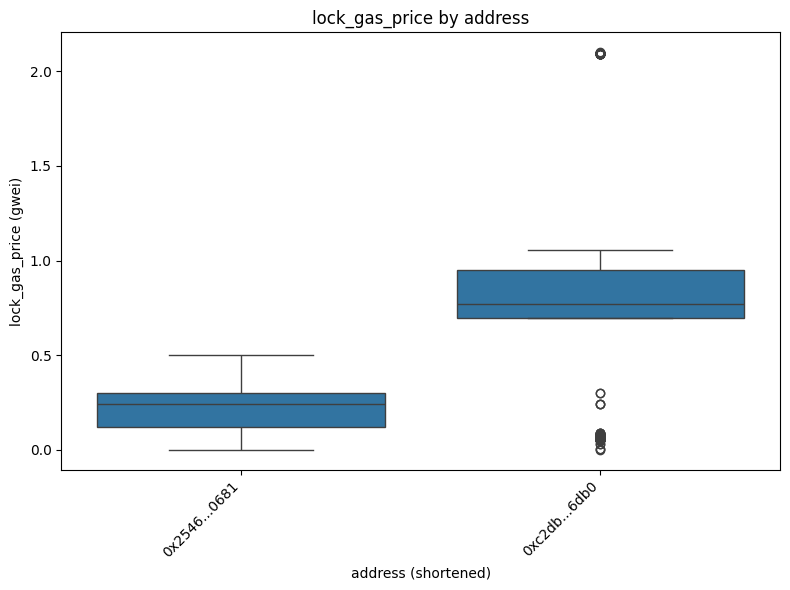

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame([
    {"address": addr, "order_id": oid, "created": created, "lock_txn": txn, "lock_gas_price": float(gas)}
    for addr, lst in data_dict.items()
    for oid, created, txn, gas in lst
])

# set timezone +8
df["created"] = pd.to_datetime(df["created"] + 8 * 3600, unit="s")

from dc_view import plot_gas_price_boxplot, compute_gas_group_stats, filter_good_suppliers

print("Group stats:")
group_stats = compute_gas_group_stats(df)
print(group_stats)

print("Good suppliers:")
good = filter_good_suppliers(group_stats, min_count=10, max_std=5)
print(good)

print("Gas price boxplot:")
plot_gas_price_boxplot(df)

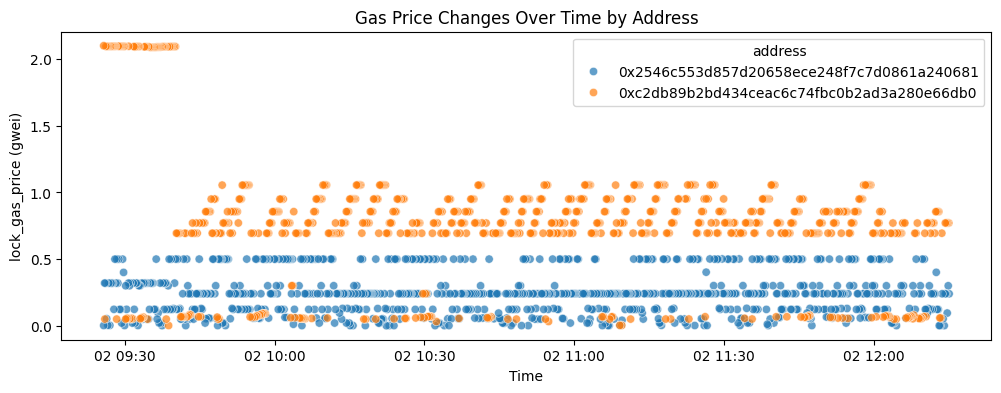

In [246]:
df["created_dt"] = pd.to_datetime(df["created"], unit="s")
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df, x="created_dt", y="lock_gas_price", hue="address", alpha=0.7)
plt.title("Gas Price Changes Over Time by Address")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()

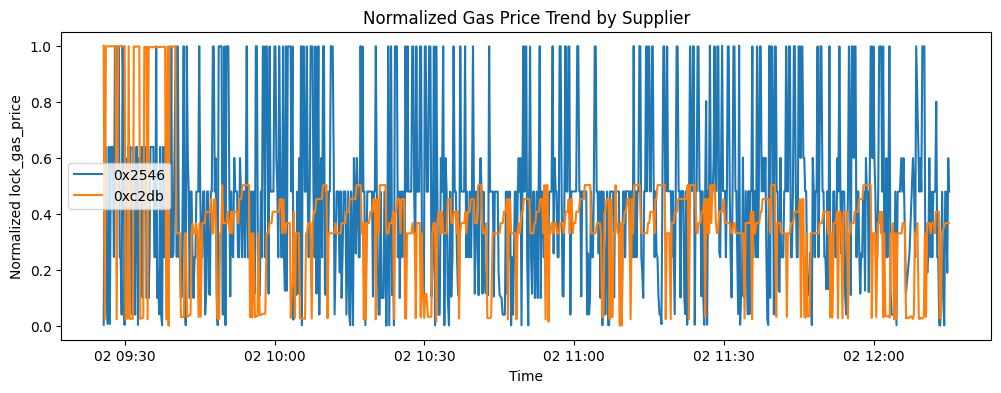

In [247]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    norm = (group["lock_gas_price"] - group["lock_gas_price"].min()) / (group["lock_gas_price"].max() - group["lock_gas_price"].min())
    plt.plot(group["created_dt"], norm, label=addr[:6])
plt.legend()
plt.title("Normalized Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("Normalized lock_gas_price")
plt.show()

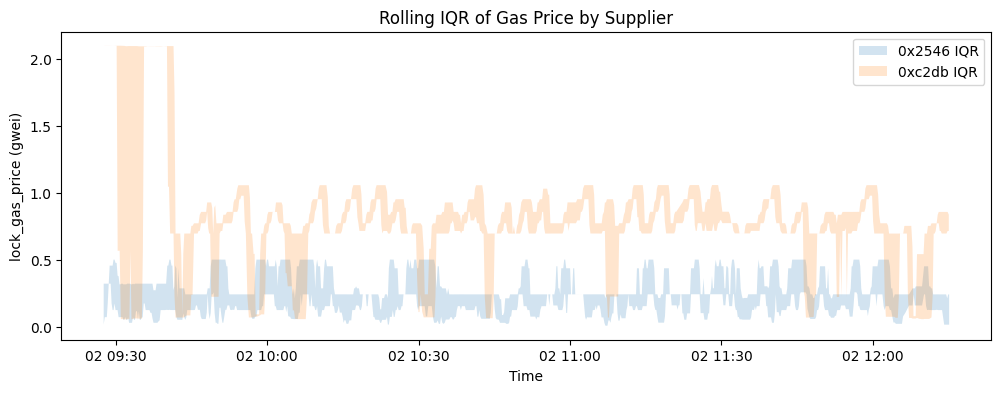

In [248]:
window = 10
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    rolling_q25 = group["lock_gas_price"].rolling(window).quantile(0.25)
    rolling_q75 = group["lock_gas_price"].rolling(window).quantile(0.75)
    plt.fill_between(group["created_dt"], rolling_q25, rolling_q75, alpha=0.2, label=f"{addr[:6]} IQR")
plt.legend()
plt.title("Rolling IQR of Gas Price by Supplier")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()


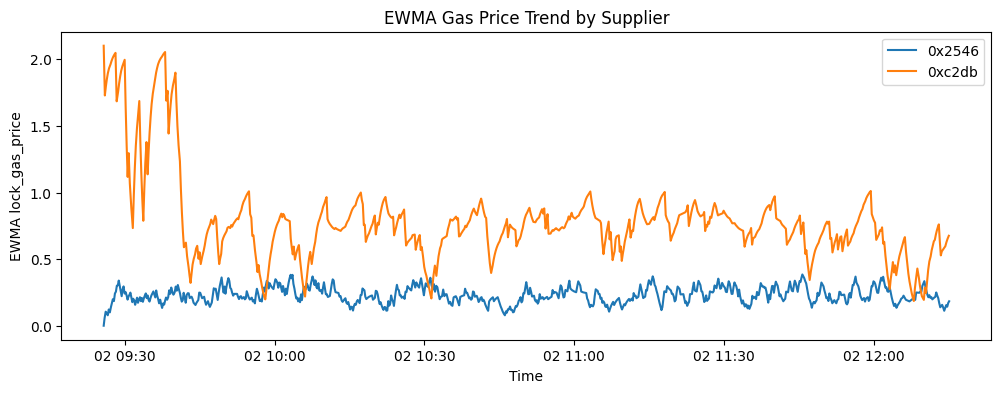

In [249]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    ewma = group["lock_gas_price"].ewm(span=10, adjust=False).mean()
    plt.plot(group["created_dt"], ewma, label=addr[:6])
plt.legend()
plt.title("EWMA Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("EWMA lock_gas_price")
plt.show()
